In [1]:
import numpy as np
from PIL import Image
import a2

# Read the image 

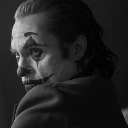

In [2]:
image = Image.open("joker.jpeg")
size_ = (128, 128)
image = image.resize(size_)
image = image.convert("L")
image

# binarize the image and read it back with no noise

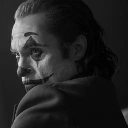

In [3]:
image = np.array(image)
bin_ = a2.binarize(image)
debin = a2.de_binarize(bin_,image.shape[0], image.shape[1])
Image.fromarray(debin)

# Adding noise to Tx bits without convolutional codes

In [4]:
# Threshold function. Outputs 1 if input is > 0.5 and 0 otherwise. Simulates hard decision thresholding for unipolor code
thresh = lambda x: 1 if x > 0.5 else 0 

In [5]:
def output(s1,s0, i):
    P1 = i ^ s0
    P2 = s1
    return [P1,P2]

def encoder(bitstream):
    # Step 1 add 2 leading zeros to simulate state
    bitstream = np.concatenate(([0, 0], bitstream))
    # Initialize and empty endcoded away 
    encoded = []
    # Iterate over the original length of th input.
    for n in range(len(bitstream)-2):
        # Concatenate the output bits
        encoded.extend(output(bitstream[n], bitstream[n+1], bitstream[n+2]))
    # remove the added state 0 bits
    bistream = bitstream[2:]
    return encoded

def output2(s1,s0, i):
    P1 = i ^ s0
    P2 = s1
    P3 = i ^ s1
    return [P1,P2,P3]

def encoder2(bitstream):
    # Step 1 add 2 leading zeros to simulate state
    bitstream = np.concatenate(([0, 0], bitstream))
    # Initialize and empty endcoded away 
    encoded = []
    # Iterate over the original length of th input.
    for n in range(len(bitstream)-2):
        # Concatenate the output bits
        encoded.extend(output2(bitstream[n], bitstream[n+1], bitstream[n+2]))
    # remove the added state 0 bits
    bistream = bitstream[2:]
    return encoded

def time_instance(n_states):
    # Wrapper of List of Dictionaries 
    # cost is initialized as infinity 
    # prev holds the index of the previous 
    # node and the decoded bit.
    return [{'cost': np.inf, 'prev': [None,None]} for _ in range(n_states)]

def machine(input_, current):
    nexts = ['00', '00', '01', '01'] if input_ == 0 else ['10', '10', '11', '11']
    return nexts[current]

def Hamming_dist(bit1, bit2): return bit1 ^ bit2

states = {'00': 0, '01':1, '10':2, '11':3}
#states_inv = {0: [False,False], 1: [False,True], 2: [True,False], 3: [True,True]}
states_inv = {0: [0,0], 1: [0,1], 2: [1,0], 3: [1,1]}
def forward_decoder(encoded):
    # Initialize the empty trellis diagram
    # Has length as the bitstream + 1 for the initial state
    instances = [time_instance(4) for _ in range(int(len(encoded)/3)+1)]
    # Initialize the initial state 
    instances[0][0]['prev'] = [0, 0]
    instances[0][0]['cost'] = 0
    # loop over the timesteps
    for i in range(len(instances)-1):
        # The observed (noisy output)
        observed_op = encoded[i*3 : (i+1)*3]
        # loop over the states
        for state in range(4):
            # If the state hasn't been reached break
            if instances[i][state]['prev'][0] is None:
                continue
            # calcutate the next state index
            next0state, next1state = states[machine(0,state)], states[machine(1,state)]
            # get the bits of the current state
            state_bits = states_inv[state]
            # use the state bits with 0 and 1 and get the output of the state-bit pair
            op = [output(state_bits[1], state_bits[0], j) for j in [0,1]]
			# Calculate the cost(Hamming dist) between the output and the observed output
            cost = [sum(list(map(Hamming_dist,observed_op,op[j]))) for j in [0,1]]
			# Update next bits if 0 bit and if 1 bit
            # Update only if the current cost is less that the cost already
            # in the next state node
            # for 0 bit (dashed line)
            
            if instances[i+1][next0state]['cost'] > cost[0] + instances[i][state]['cost']:
                instances[i+1][next0state]['prev'] = [state, 0]
                instances[i+1][next0state]['cost'] = cost[0] + instances[i][state]['cost']
			# repeat for the 1 bit  (solid line)
            if instances[i+1][next1state]['cost'] > cost[1] + instances[i][state]['cost']:
                instances[i+1][next1state]['prev'] = [state, 1]
                instances[i+1][next1state]['cost'] = cost[1] + instances[i][state]['cost']        

    return instances
def viterbi_decode(instances):
    # Get the minimum state based on cost at the last instance
    min_state = min(instances[len(instances) - 1], key = lambda x: x['cost'])
    # Get previous state and decoded bit
    prev_state = instances[len(instances) - 2][min_state['prev'][0]]
    bit = min_state['prev'][1]
    # Initialize the result array
    result = [bit]
    # Loop over the middle time instances
    for inst in range(len(instances)-2,0,-1):
        # Get previous state and decoded bit
        bit = prev_state['prev'][1]
        prev_state = instances[inst -1][prev_state['prev'][0]]
        # Append to the result
        result.append(bit)
    # Return the revered array.
    return result[::-1]
def decode(encoded): return viterbi_decode(forward_decoder(encoded))


In [6]:
bs = np.random.choice([0, 1],500,p = [0.5, 0.5])
SNR = 20
en = encoder2(bs)

awgn = np.random.normal(scale = np.sqrt(1/SNR), size = len(en))
noise = list(map(thresh, awgn + en))

print(sum(decode(noise) != bs))

4


### With SNR = 1 (linear not in dB)

Root mean square error = 7.949766757830462


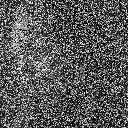

In [7]:
SNR = 1
awgn = np.random.normal(scale = np.sqrt(1/SNR), size = len(bin_))

bin_with_noise = list(map(thresh, awgn + bin_))
debin_with_noise = a2.de_binarize(bin_with_noise,image.shape[0], image.shape[1])
decoded = Image.fromarray(debin_with_noise)
print(f"Root mean square error = {a2.rmse(image,decoded)}")
Image.fromarray(debin_with_noise)

### With SNR = 10 (linear not in dB)

Number of bit errors: 7407 = 5.651092529296875 %
Root mean square error = 2.6748658333760407


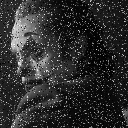

In [8]:
SNR = 10
awgn = np.random.normal(scale = np.sqrt(1/SNR), size = len(bin_))

bin_with_noise = list(map(thresh, awgn + bin_))
debin_with_noise = a2.de_binarize(bin_with_noise,image.shape[0], image.shape[1])
print(f"Number of bit errors: {sum(bin_with_noise != bin_)} = {sum(bin_with_noise != bin_)/len(bin_)*100} %")
decoded = Image.fromarray(debin_with_noise)
print(f"Root mean square error = {a2.rmse(image,decoded)}")
Image.fromarray(debin_with_noise)

### With SNR = 30 (linear not in dB)

394
Root mean square error = 0.5125381083392727


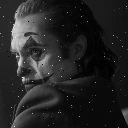

In [9]:
SNR = 30
awgn = np.random.normal(scale = np.sqrt(1/SNR), size = len(bin_))

bin_with_noise = list(map(thresh, awgn + bin_))
print(sum(bin_with_noise != bin_))
debin_with_noise = a2.de_binarize(bin_with_noise,image.shape[0], image.shape[1])
decoded = Image.fromarray(debin_with_noise)
print(f"Root mean square error = {a2.rmse(image,decoded)}")
Image.fromarray(debin_with_noise)

# Repeating the same process, but with convolutional channel codes using this encoder

![Encoder](Encoder_BD.jpg)

In [13]:
encoded = a2.encoder(bin_)
encoded = np.array(encoded)

### With SNR = 3 (linear not in dB) ... Rate = 1/3

Number of bit errors: 14051 = 10.720062255859375 %
Root mean square error = 3.7965615225531706


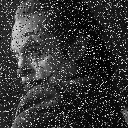

In [20]:
SNR = 3
awgn = np.random.normal(scale = np.sqrt(1/SNR), size = len(encoded))
bin_with_noise = np.array(list(map(thresh, awgn + encoded)))
decoded_bin_with_noise = a2.decode(bin_with_noise)
print(f"Number of bit errors: {sum(decoded_bin_with_noise != bin_)} = {sum(decoded_bin_with_noise != bin_)/len(bin_)*100} %")
debin_with_noise = a2.de_binarize(decoded_bin_with_noise,image.shape[0], image.shape[1])
decoded = Image.fromarray(debin_with_noise)
print(f"Root mean square error = {a2.rmse(image,decoded)}")
decoded

### With SNR = 10 (linear not in dB) ... Rate = 1/3

Number of bit errors: 335 = 0.255584716796875 %
Root mean square error = 0.49975579974123363


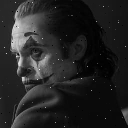

In [14]:
SNR = 10
awgn = np.random.normal(scale = np.sqrt(1/SNR), size = len(encoded))
bin_with_noise = np.array(list(map(thresh, awgn + encoded)))
decoded_bin_with_noise = a2.decode(bin_with_noise)
print(f"Number of bit errors: {sum(decoded_bin_with_noise != bin_)} = {sum(decoded_bin_with_noise != bin_)/len(bin_)*100} %")
debin_with_noise = a2.de_binarize(decoded_bin_with_noise,image.shape[0], image.shape[1])
decoded = Image.fromarray(debin_with_noise)
print(f"Root mean square error = {a2.rmse(image,decoded)}")
decoded

### With SNR = 20 (linear not in dB) ... Rate = 1/3

Number of bit errors: 2 = 0.00152587890625 %
Root mean square error = 0.034938562148434216


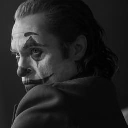

In [17]:
SNR = 20
awgn = np.random.normal(scale = np.sqrt(1/SNR), size = len(encoded))
bin_with_noise = np.array(list(map(thresh, awgn + encoded)))
decoded_bin_with_noise = a2.decode(bin_with_noise)
print(f"Number of bit errors: {sum(decoded_bin_with_noise != bin_)} = {sum(decoded_bin_with_noise != bin_)/len(bin_)*100} %")
debin_with_noise = a2.de_binarize(decoded_bin_with_noise,image.shape[0], image.shape[1])
decoded = Image.fromarray(debin_with_noise)
print(f"Root mean square error = {a2.rmse(image,decoded)}")
decoded